In [196]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [197]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [198]:
train = pd.read_csv('train.csv', index_col=0)

In [199]:
test = pd.read_csv('test.csv', index_col=0)

In [200]:
train['isTrain'] = True
test['isTrain'] = False

In [201]:
X = train.append(test, sort=False)

In [202]:
X.describe().T

count         mean          std        min          25%          50%          75%          max
id         8765.0  4404.586366  2542.532548   1.000000  2207.000000  4403.000000  6603.000000  8811.000000
atm_group  8765.0  4407.008842  2427.934099  32.000000  1942.000000  5478.000000  5478.000000  8083.000000
lat        8345.0    54.138304     4.329293  42.057080    52.243997    55.060936    56.116673    69.495093
long       8345.0    63.500873    32.787366  19.941530    37.851107    49.071694    84.950218   173.706490
target     6261.0     0.000715     0.085852  -0.145001    -0.061176    -0.015573     0.040149     0.218608

In [203]:
X.describe(include='object').T

count unique                                                top freq
address      8765   7481             HOROSHEVSKOE SH,V38       MOSKVA          7
address_rus  8345   6147  квартал В-13, городской округ Волгодонск, Рост...   10

### Количество банкоматов стоящих по одному адресу

In [204]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [205]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [206]:
X.head()

id  atm_group                                 address                                        address_rus  ...          long    target  isTrain  count
0  8526.0       32.0  EMELYANOVA,34          Y-SAKHALINSK     улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...  ...    142.738319  0.011500     True    1.0
1  8532.0       32.0  KOMSOMOLSKAYA,259B     Y.SAKHALINSK     Комсомольская улица, 259, Южно-Сахалинск, Саха...  ...    142.753348  0.029710     True    1.0
2  8533.0       32.0  KOMMUN. PR., 32        YUZHNO SAKHAL    Коммунистический проспект, Южно-Сахалинск, Сах...  ...    142.741113  0.009540     True    1.0
3  8684.0       32.0  LENINGRADSKIY PR.,76A  MOSCOW           Ленинградский проспект, 76А, Москва, Россия, 1...  ...     37.515146 -0.094035     True    1.0
4    37.0       32.0  GVARDEYSKAYA PL., 2    NORILSK          Гвардейская площадь, 2, Норильск, Красноярский...  ...     88.211228  0.079277     True    1.0

[5 rows x 9 columns]

### Расстояния до ближайших банкоматов

In [207]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [208]:
knc = KNeighborsClassifier(metric=distance)

In [209]:
dots = X[['lat','long']].dropna()

In [210]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7ff3e6431048>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [211]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [212]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [213]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [214]:
dots=dots.drop(columns=['lat','long'])

In [215]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [216]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [217]:
X.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain', 'count', 'distance_1', 'indexes_1', 'distance_2',
       'indexes_2', 'distance_3', 'indexes_3', 'distance_4', 'indexes_4',
       'distance_5', 'indexes_5', 'mean', 'city'],
      dtype='object')

In [218]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index

In [219]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [220]:
X.city= X.city.rank().fillna(-1)

In [139]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city']]
Y_ = X.loc[X.isTrain, 'target']

In [140]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)

In [141]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [142]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0792103
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0745175
[3]	valid_0's rmse: 0.0705317
[4]	valid_0's rmse: 0.0671016
[5]	valid_0's rmse: 0.0641692
[6]	valid_0's rmse: 0.0616998
[7]	valid_0's rmse: 0.0595902
[8]	valid_0's rmse: 0.0575512
[9]	valid_0's rmse: 0.056037
[10]	valid_0's rmse: 0.054788
[11]	valid_0's rmse: 0.0536961
[12]	valid_0's rmse: 0.0526001
[13]	valid_0's rmse: 0.0517706
[14]	valid_0's rmse: 0.0509879
[15]	valid_0's rmse: 0.0504143
[16]	valid_0's rmse: 0.0499533
[17]	valid_0's rmse: 0.0495757
[18]	valid_0's rmse: 0.0491666
[19]	valid_0's rmse: 0.0488564
[20]	valid_0's rmse: 0.0485702
[21]	valid_0's rmse: 0.0483905
[22]	valid_0's rmse: 0.0481961
[23]	valid_0's rmse: 0.0479803
[24]	valid_0's rmse: 0.0478828
[25]	valid_0's rmse: 0.0477505
[26]	valid_0's rmse: 0.047599
[27]	valid_0's rmse: 0.047524
[28]	valid_0's rmse: 0.0474433
[29]	valid_0's rmse: 0.0473823
[30]	valid_0's rmse: 0.0472947
[31]	valid_0's rmse: 0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

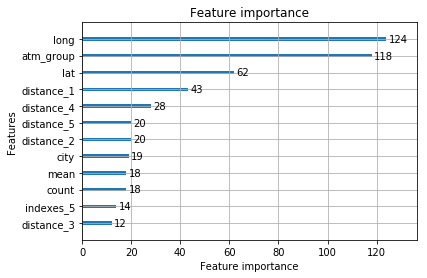

In [143]:
%matplotlib inline
lgb.plot_importance(gbm)

In [144]:
rmse(Y_valid, gbm.predict(X_valid))

0.045904893145415314

In [145]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08463725683992336

In [146]:
X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                        'distance_2', 'distance_3',  'distance_4', 'distance_5',
                        'indexes_5', 'mean', 'city']]

In [147]:
baseline = pd.read_csv("submit.csv",index_col=0)

In [148]:
submit=gbm.predict(X_test)

In [149]:
rmse(baseline.target.values,submit)

5.7051022692293534e-18

In [32]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])

In [35]:
submit.to_csv('submit.csv')